## CNN inference example in Pytorch

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

import pycomlink as pycml
from pycomlink.processing.pytorch_util import run_inference

c:\Users\lukas\Documents\OpenSense\pycomlink\pycomlink\io\examples.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Load data
data_path = pycml.io.examples.get_example_data_path()
cmls = xr.open_dataset(data_path + '/example_cml_data.nc')

# select 3 different CMLs to study
cmls = cmls.isel(cml_id = [0, 10, 370])

# Remove outliers, compute tl and interpolate missing values
cmls['tsl'] = cmls.tsl.where(cmls.tsl != 255.0)
cmls['rsl'] = cmls.rsl.where(cmls.rsl != -99.9)
cmls['tl'] = cmls.tsl - cmls.rsl # calculate total loss (previous TRSL)
cmls['tl'] = cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

In [3]:
# Dataarray shape is expected to be (time, channels, cml_id)
tl = cmls.tl.transpose('time', 'channel_id', 'cml_id')

# Normalisation
tl_normed = tl - tl.median(dim='time')

# TODO: Isn't standardization still needed ?

### Option 1: Load DL model and set up a path for model weights

In [4]:
# Loading from file should support .pt2 and optional config.yml 
# also with hardcoded reflength: 60 if the config isn't available

# Set up your own path:
weights_path = 'C:/Users/lukas/.cml_wd_pytorch/models/model_epoch_15.pth'
result = run_inference.cnn_wd(model_path_or_url=weights_path, data=tl_normed)

### Option 2: Load the model from URL and cahe it

In [6]:
# TODO: We need one simple class for example polz_2025_cnn, which loads specific cnn.py model and weights in .pt2 file from url
# so none of those will be in pycomlink
# the user should only choose a model by a name and the rest of the complexity is hidden
# leave the url option
# config should be optional, if its not provided, set reflength: 60  # Length of the radar data to consider for rainfall rate or wet label calculation

## something like this:
#model_url = "https://github ... .pt2"
#config_url_or_path = ...       # if none, reflength will be set to 60
#result = pytorch_util.cnn_wd(model_url, config_url_or_path, data=tl_normed)


model_URL = "https://github.com/jpolz/cml_wd_pytorch/raw/refs/heads/main/data/dummy_model/model_epoch_15.pth"
result = run_inference.cnn_wd(model_path_or_url=model_URL,data=tl_normed)

Model cached at C:\Users\lukas\.cml_wd_pytorch\models\model_9e2209318183e5057cf2a88597353c3a.pth


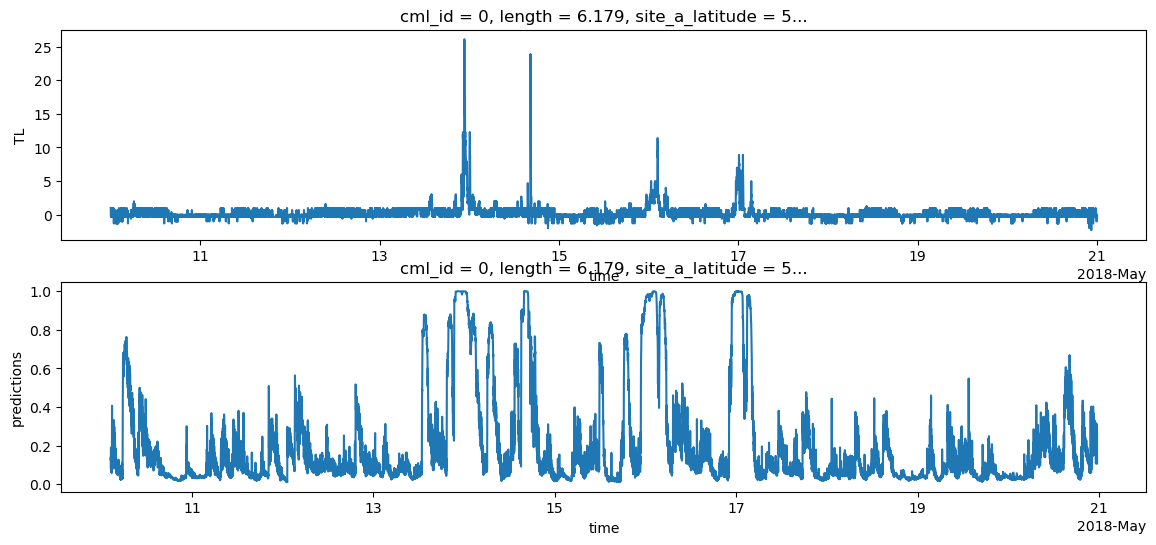

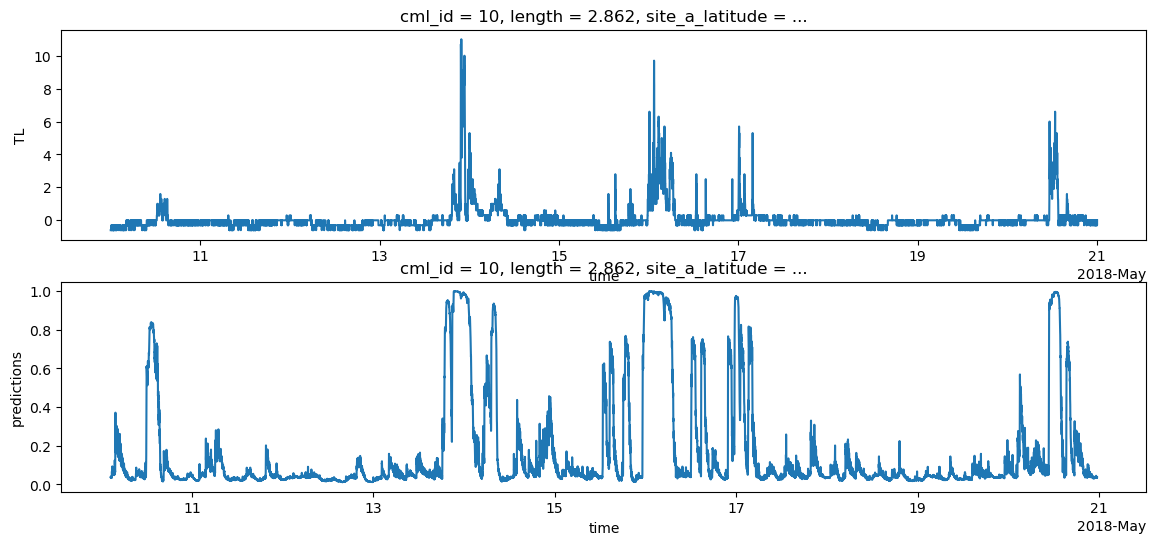

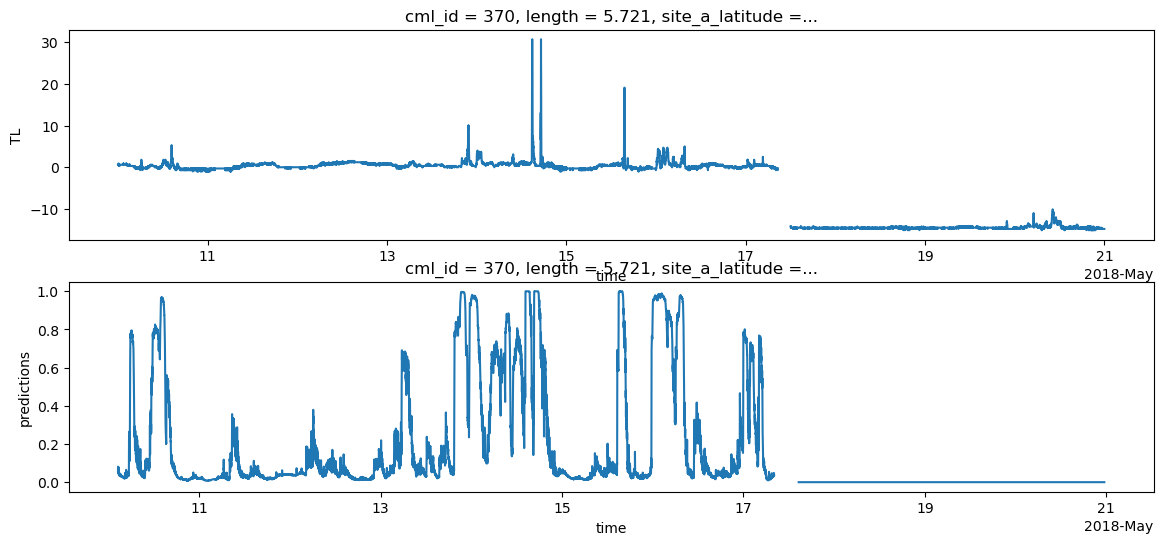

In [7]:
for cml_id in cmls.cml_id.data:
    fig, axs = plt.subplots(2, 1, figsize=(14, 6))
    result.TL.sel(cml_id=cml_id).isel(channel_id=0).plot.line(x='time', ax=axs[0])
    result.predictions.sel(cml_id=cml_id).plot.line(x='time', ax=axs[1])
    
